# Conditional Deep Convolutional Generative Adversarial Network

If you have not gone through my DCGAN notebook, than please do so by clicking on this [Link](https://github.com/raja-git-ai/GAN/blob/master/DCGAN/FASHION_MNIST_DCGAN.ipynb)

### Brief about CDCGAN
1.) CDCGAN basically refers to generating an image or a multidimensional image like array on the basis of user input or directed input.<br>
2.) In our current implementation we can ask the generator model to generate a class of image like bag shoes, tshirt's etc by givin user input.<br>
3.) Basically we specify a class of image and the network spits out relevent image/data.

4.) where as a DCGAN spits out image of any class.

5.) CDCGAN Network architecture.

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/05/Example-of-a-Conditional-Generator-and-a-Conditional-Discriminator-in-a-Conditional-Generative-Adversarial-Network-1024x887.png" width="500"/><br>
Taken from Conditional Generative Adversarial Nets, 2014.


### Implementation idea
#### Generator :- 
1.) We create a Generator which can take random noise and class of image(9 for shoe, 8 for bag etc) as input.<br>
2.) Random noise is resized to a shape of image with multiple channel.<br>
3.) Class of image will also be resized to shape of a image but with single channel.<br>

#### Descriminator :- 
1.) We create a descriminator which can take a multichannel real image or multichannel fake image produced by generator. <br>
2.) Class label of image and a label which specifies whether the ultichannel image is fake or real.<br>
3.) Generator and Descriminator are trained simultaniously.<br>
4.) Finally the generator is picked up and used to prduce veriety of images within the class provided by user.

In [1]:
# Importing neccessary libraries
import numpy as np
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,Reshape,Conv2DTranspose,Dense,Flatten,LeakyReLU,Dropout,Embedding,Input,Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [112]:
# Loading the data 
(X_train,y_train),(X_test,y_test) = load_data()
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test,axis=1)
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
# Resizing image
X_train = (X_train - 127.5)/127.5
X_test = (X_test - 127.5)/127.5
print("Shape of taining examples-> ",X_train.shape,y_train.shape)
print("Shape of test examples-> ",X_test.shape,y_test.shape)

Shape of taining examples->  (60000, 28, 28, 1) (60000,)
Shape of test examples->  (10000, 1, 28, 28) (10000,)


In [54]:
X_train.shape

(60000, 28, 28, 1)

In [59]:
X_train.min()

-1.0

In [60]:
# We can see that lables are presented as numbers , which going forward we will create a exact lable mapping.
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

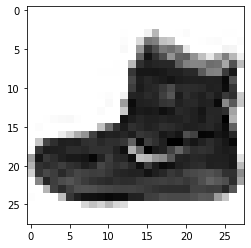

In [61]:
# Plot raw pixel data
plt.imshow(X_train[0,:,:,0],cmap='gray_r')

In [62]:
input_shape = (28,28,1)
num_classes = 10
noise_points = 100
# Define descriminator 
def get_descriminator():
  #1. We need to define one embedding layer 
  #2. We have to resize the embedding layer to match up with the conv layer and will have to blow it up to match the conv layer sizes
  # Preparing the Embedding Layer
  # Plan is to add the class label as a channel in the overall image 
  # 1. Taking the input
  input_label = Input(shape=(1,))
  # 2. Creating a 50 dimensional embdding out of the input
  embedding = Embedding(input_dim=num_classes,output_dim=50)(input_label)
  # 3. Blowing up the input to a shape of 28*28
  embedding = Dense(input_shape[0]*input_shape[1])(embedding)
  # 4. Creating a 28*28 square matrix out of dense layer
  embedding = Reshape((input_shape[0],input_shape[1],1))(embedding)

  ########################################################3
  # 5. Taking the image input
  input_image = Input(shape=input_shape)
  
  # 6. Concatenating the input image with the class label from step 4
  class_and_image = Concatenate()([input_image,embedding])

  # Preparing the conv layer
  convolve = Conv2D(128,kernel_size=(4,4),strides=(1,1),padding='same')(class_and_image)
  convolve = LeakyReLU(alpha=0.2)(convolve)

  convolve = Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same')(convolve)
  convolve = LeakyReLU()(convolve)

  convolve = Flatten()(convolve)
  convolve = Dropout(0.2)(convolve)

  convolve = Dense(1,activation='sigmoid')(convolve)
  
  model = Model([input_image,input_label],convolve)
  model.compile(loss='binary_crossentropy',optimizer = Adam(lr=0.002),metrics=['accuracy'])
  print(model.summary())
  return model

In [63]:
# Getting descriminator
descriminator = get_descriminator()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 50)        500         input_13[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 1, 784)       39984       embedding_6[0][0]                
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [64]:
# define generator
def get_gnerator():
  # Goal is to take class label as input and add it with random noise.
  # Further blow it up to form a square matrix representing 2 channel image 

  # 1. Creating embedding layer
  input_label = Input(shape=(1,))
  embedding = Embedding(num_classes,50)(input_label)
  tot_nodes = 1* 7*7
  embedding = Dense(tot_nodes)(embedding)
  embedding = Reshape((7,7,1))(embedding)

  # 2. Creating layer to ingest random noise i.e feeding the latent layer
  latent = Input(shape=(noise_points,))
  tot_nodes = 128*7*7
  gen = Dense(tot_nodes)(latent)
  gen = LeakyReLU(alpha=0.2)(gen)
  # Reshaping the layer to be a size of 7*7*128
  gen = Reshape((7,7,128))(gen)
  # Merging the embedding layer representing class with noise layer
  gen = Concatenate()([gen,embedding])
  # Upsample to 14 * 14 
  gen = Conv2DTranspose(filters=128,kernel_size= (5,5),strides=(2,2),padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)

  # Upsample to 28*28 
  gen = Conv2DTranspose(filters=128,kernel_size = (4,4),strides=(2,2),padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen) 
  # Out layer 
  out_layer = Conv2D(1,(7,7),activation='tanh',padding='same')(gen)

  # Define model 
  model = Model([latent,input_label],out_layer)
  print(model.summary())
  return model 

In [65]:
# Get descriminator
generator = get_gnerator()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 6272)         633472      input_16[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
______________________________________________________________________________________

In [66]:
# Define CDCGAN model 
def cdcgan(generator,descriminator):
  descriminator.trainable = False
  gen_noise,gen_label = generator.input
  gen_output = generator.output 
  # output from descriminator
  cdcgan_output = descriminator([gen_output,gen_label])
  # defining model
  cdcgan_model = Model([gen_noise,gen_label],cdcgan_output)
  cdcgan_model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.0002,beta_1=0.5))
  print(cdcgan_model.summary())
  return cdcgan_model

In [67]:
cdcgan_model = cdcgan(generator,descriminator)

Model: "functional_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 6272)         633472      input_16[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 50)        500         input_15[0][0]                   
______________________________________________________________________________________

In [82]:
# get batch of training data
def get_actual_data(batch_size,X_train,y_train):
  random_idx = np.random.randint(0,X_train.shape[0],batch_size)
  X_sample = X_train[random_idx]
  real_lables = y_train[random_idx]
  # LAbel for the GAN which indicates these are actual images from the dataset
  y_real = np.ones((batch_size,1))
  return X_sample,real_lables,y_real

def generate_latent_points(latent_dim,n_samples,n_classes=10):
  # Generate random points in latent sapce
  X_rand_latent = np.random.randn(latent_dim*n_samples)
  X_rand_latent = X_rand_latent.reshape(n_samples,latent_dim)
  y_rand_label = np.random.randint(0,n_classes,n_samples)
  return X_rand_latent,y_rand_label

def generate_random_fake_samples(batch_size,classes = 10):
    X_fake,fake_lables = generate_latent_points(noise_points,batch_size)
    # Creating images out of fake samples 
    fake_images = generator([X_fake,fake_lables])
    y_fake  = np.zeros((batch_size,1))

    return fake_images,fake_lables,y_fake 

In [83]:
def train(generator,descriminator,X_train,y_train,noise_points,num_epocs=100,num_batch=128):

    batch_per_epocs = X_train.shape[0]//num_batch
    half_batch = num_batch//2

    for i in range(num_epocs):
      for j in range(batch_per_epocs):
        X_real_sample,y_pred_real_sample,y_real = get_actual_data(num_batch,X_train,y_train)
        # Train Descriminator on real samples and update weights
        descriminator_loss1,_ = descriminator.train_on_batch([X_real_sample,y_pred_real_sample],y_real)
        # Get Fake data or generated Data
        X_fake,fake_lables,y_fake = generate_random_fake_samples(num_batch)
        # Train Descriminator on fake results 
        descriminator_loss2,_ = descriminator.train_on_batch([X_fake,fake_lables],y_fake)
        # Generate latent points to train the CGAN
        X_rand_latent,y_rand_label = generate_latent_points(noise_points,num_batch)
        # We will create an array of 1 for the output label of fake samples 
        # IT will help us to calculate the GAN loss
        y_gan = np.ones((num_batch,1))
        gen_loss = cdcgan_model.train_on_batch([X_rand_latent,y_rand_label],y_gan)
        # Print summary of loss per cycle 
      print("batch, epoch, descriminator loss 1,2 gan loss")
      print(i,j,descriminator_loss1,descriminator_loss2,gen_loss)
    # Save the model after training 
    generator.save_weights("cdcgan_model.h5")

In [ ]:
# Begin training 
train(generator,descriminator,X_train,y_train,noise_points,num_epocs=100,num_batch=128)

In [ ]:
# Load existing model 
generator.load_weights("cdcgan_model.h5")

### Testing the model

In [105]:
# Generate latent/random points for 3 random inputs
X_rand_latent,y_rand_label = generate_latent_points(noise_points,3)
y_rand_label = np.array([9,8,7])

In [106]:
# Our object dictionary
obj_dict = {'t-shirt':0, 'trouser':1, 'pullover':2, 'dress':3, 'coat':4, 'sandal':5,
            'shirt':6, 'sneaker':7, 'bag':8,'ankle boot':9}

In [107]:
# We are producing generated images for class label 
# 1. Boot
# 2. Bag 
# 3. Sneaker
y_pred = generator.predict([X_rand_latent,y_rand_label])

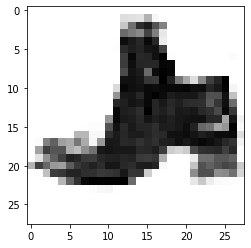

In [108]:
# So as per our key value dictionary we are have generated below image for ankle boot
# Which referrs to key 9
plt.imshow(y_pred[0,:,:,0],cmap='gray_r')

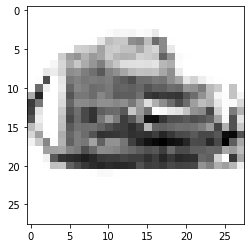

In [109]:
# So as per our key value dictionary we are have generated below image for a bag
# Which referrs to key 8
plt.imshow(y_pred[1,:,:,0],cmap='gray_r')

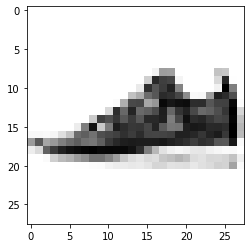

In [110]:
# So as per our key value dictionary we are have generated below image for a sneaker or close to sneaker
# Which referrs to key 7
plt.imshow(y_pred[2,:,:,0],cmap='gray_r')